In [1]:
import torch
from xtfc_model import ValueFunctionModel
from hparams import hparams
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = ValueFunctionModel(in_dim=2, out_dim=1, hparams=hparams).to(device)
model.load_state_dict(torch.load("models\inverted-pendulum_xtfc-unfreeze_[50]_SiLU.pt", map_location=device))
model.eval()

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\arnav\AppData\Local\Temp\ipykernel_23060\724517221.py:3: SyntaxWarning: invalid escape sequence '\i'
  model.load_state_dict(torch.load("models\inverted-pendulum_xtfc-unfreeze_[50]_SiLU.pt", map_location=device))


ValueFunctionModel(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
  )
  (y): Linear(in_features=50, out_features=1, bias=False)
  (activation): SiLU()
)

In [4]:
def wrap_angle(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ((angle + np.pi) % (2 * np.pi)) - np.pi
    return wrapped

In [5]:
class PendulumState:
    def __init__(self, model, hparams):
        self.theta = 1.0
        self.theta_dot = 1.0
        self.control_input = 0.0
        self.time = 0.0
        self.model = model
        self.hparams = hparams

        self.g = hparams['gravity']
        self.l = hparams['length']
        self.m = hparams['mass']

        self.q = hparams['Q']
        self.r = hparams['R']

    def compute_control_input(self, grad_v):
        V_x2 = grad_v[1]
        u = -V_x2 / (2 * self.l**2 * self.m * self.r[0, 0])
        return u

    def step(self, dt, control_input):
        state_tensor = torch.tensor([self.theta, self.theta_dot], dtype=torch.float32, device=device)
        g_x, g_0, v, grad_v = self.model.get_outputs(state_tensor)
        u = self.compute_control_input(grad_v)

        f_x1 = self.theta_dot
        f_x2 = (self.g / self.l) * torch.sin(torch.tensor(self.theta)).item()
        g_x2 = 1 / (self.m * self.l * self.l)

        theta_dot_dot = f_x2 + g_x2 * u

        self.theta = wrap_angle(self.theta + f_x1 * dt)
        self.theta_dot = self.theta_dot + theta_dot_dot * dt
        self.control_input = u
        self.time += dt

C:\Users\arnav\AppData\Local\Temp\ipykernel_23060\1468860001.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_x2 = (self.g / self.l) * torch.sin(torch.tensor(self.theta)).item()


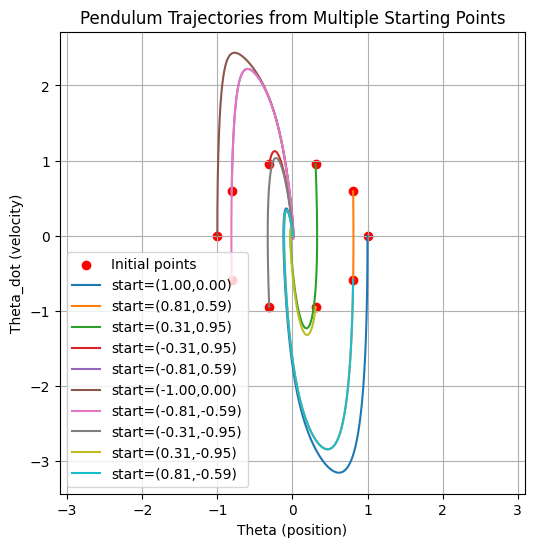

In [ ]:
import matplotlib.pyplot as plt

# Define multiple starting points (theta, theta_dot)
num_points = 10
radius = 1.0
starting_points = [
    (radius * np.cos(2 * np.pi * i / num_points), radius * np.sin(2 * np.pi * i / num_points))
    for i in range(num_points)
]

plt.figure(figsize=(6, 6))
circle_points = np.array(starting_points)
plt.scatter(circle_points[:, 0], circle_points[:, 1], c='red', label='Initial points')

dt = 0.001
steps = 10000

for theta0, theta_dot0 in starting_points:
    pendulum = PendulumState(model, hparams)
    pendulum.theta = theta0
    pendulum.theta_dot = theta_dot0

    positions = []
    velocities = []

    for _ in range(steps):
        positions.append(pendulum.theta)
        velocities.append(pendulum.theta_dot)
        pendulum.step(dt, pendulum.control_input)

        if abs(pendulum.theta) + abs(pendulum.theta_dot) < 1e-3:
            break

    # Convert tensors to numpy arrays for plotting
    positions_np = [p.detach().numpy() if isinstance(p, torch.Tensor) else p for p in positions]
    velocities_np = [v.detach().numpy() if isinstance(v, torch.Tensor) else v for v in velocities]

    plt.plot(positions_np, velocities_np, label=f"start=({theta0:.2f},{theta_dot0:.2f})")

plt.xlabel("Theta (position)")
plt.ylabel("Theta_dot (velocity)")
plt.title("Pendulum Trajectories from Multiple Starting Points")
plt.grid(True)
plt.axis('equal')
plt.show()